In [1]:
import pandas as pd
import numpy as np

In [9]:
title = 'rsa'
input_file = '../output/paa/{}_paa_results.csv'.format(title)
output_file = '../output/paa/{}_paa_output.csv'.format(title)
answer_file = '../output/paa/{}_answers.txt'.format(title)

df = pd.read_csv(input_file)

## Clean up the answer text (skip this if already cleaned during crawling process script)

In [10]:
df['answer'] = df['answer'].str.replace('\n', ' ', regex=True) \
        .replace('[\.][\.][\.]', '', regex=True) \
        .replace('[a-zA-Z]{3} [0-9]{1,2}, [0-9]{4}', '', regex=True) \
        .replace('More items', '', regex=True) \
        .replace('\s+', ' ', regex=True) \
        .replace('[^a-zA-Z0-9.,:?\s\-\'\(\)]', '', regex=True)

df['answer'] = df['answer'].str.strip('"')
df['answer'] = df['answer'].str.strip('”')
pd.set_option('display.max_colwidth', -1)
df.head()

,job_title,rank,question,answer,link
0,retail sales associate,0,What are the duties of a retail sales associate?,"Sales Associate Responsibilities: Greeting customers, responding to questions, improving engagement with merchandise and providing outstanding customer service. Operating cash registers, managing financial transactions, and balancing drawers. Achieving established goals.",https://www.betterteam.com/sales-associate-job-description
1,retail sales associate,1,What is the average hourly wage for a retail sales associate?,A Retail Sales Associate is typically paid an average hourly wage of around 11.15 per hour.,https://www.careerbuilder.com/insights/retail-sales-associate
2,retail sales associate,2,How old do you have to be to be a retail sales associate?,16 Years Old,https://www.snagajob.com/search/q-sales+associate+minimum+age+16+years+old
3,retail sales associate,3,What employers look for in a sales associate?,7 Top Traits Employers Look For In A Sales Candidate Communication skills. Strong communication is the one common trait at the top of any employer's wish list for a potential sales employee. Technological skills. Responsible driver. Passion for learning. Fun. Team player. Hip.,https://talentegg.ca/incubator/2013/10/22/top-traits-employers-look-for-in-a-sales-candidate/
4,retail sales associate,4,What does a retail associate do?,"They provide a variety of services, from helping you pick out items to ringing up your purchases. Like cashiers, retail sales associates use cash registers to process transactions and are responsible for keeping track of all the money inside.",https://m.snagajob.com/job-descriptions/retail-associate/


In [11]:
df.to_csv(output_file, index=False)
np.savetxt(answer_file, df['answer'].values, fmt='%s')
# df[['answer']].to_csv(output_file, index=False, header=None)

## Investigate on different clustering approaches

### tfidf and kmeans

In [11]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


def process_text(text, stem=True):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words=set(stopwords.words('english'))
    
    tokens = [x for x in tokens if x not in stop_words]
    
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    return tokens

def cluster_text(texts=None,  vectors=None, clusters=3):
    if vectors is None:  ## Todo, note down this trick
        vectorizer = TfidfVectorizer(tokenizer=process_text,
                                     max_df=0.5,
                                     min_df=0.1,
                                     lowercase=True)
        vectors = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(vectors)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering

In [12]:
questions = list(df['question'])
clusters_tfidf_kmeans = cluster_text(texts=questions,clusters=10)
# pprint(dict(clusters_tfidf_kmeans))
for i in range(len(clusters_tfidf_kmeans)):
    print("Group", i)
    print(df.loc[clusters_tfidf_kmeans[i], ['question']].to_string(header=False))
    print("====================")

Group 0
5   How can I be a good customer service representative?
6   How would you describe good customer service?       
10  What makes a good customer experience?              
25  How can I be a good customer service agent?         
29  How do you deliver good customer service examples?  
Group 1
8   What does a customer service representative do?                  
16  What are the benefits of being a customer service representative?
17  What do you need to be a customer service representative?        
23  How can I succeed as a customer service representative?          
Group 2
3   Is customer service a good job?                              
9   Is customer support a good job?                              
11  What are the job duties of a customer service representative?
14  What is a customer service job?                              
Group 3
7   What does customer service mean to you best answer?
27  What does customer service mean to you answer?     
28  What is a good customer

### word2vec and kmeans

#### Use self-trained word2vec model

In [13]:
from gensim.models import Word2Vec

questions_tokens = [process_text(x) for x in questions]
model = Word2Vec(questions_tokens, min_count=1)
# one extra step for moving from word level to sentence level.
def sent_vectorizer(sent, model):
    sent_vec = []
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model.wv[w]
            else:
                sent_vec = np.add(sent_vec, model.wv[w])
            numw += 1
        except:
            pass
    return np.asarray(sent_vec) / numw

X_w2v = []
for q in questions_tokens:
    X_w2v.append(sent_vectorizer(q, model))
clusters_w2v_kmeans = cluster_text(vectors=X_w2v,clusters=10)
# pprint(dict(clusters_w2v_kmeans))

for i in range(len(clusters_w2v_kmeans)):
    print("Group", i)
    print(df.loc[clusters_w2v_kmeans[i], ['question']].to_string(header=False))
    print("====================")

Group 0
3  Is customer service a good job?
9  Is customer support a good job?
Group 1
8   What does a customer service representative do?                  
11  What are the job duties of a customer service representative?    
14  What is a customer service job?                                  
16  What are the benefits of being a customer service representative?
17  What do you need to be a customer service representative?        
Group 2
5   How can I be a good customer service representative?   
23  How can I succeed as a customer service representative?
25  How can I be a good customer service agent?            
Group 3
7   What does customer service mean to you best answer?
27  What does customer service mean to you answer?     
28  What is a good customer service answer?            
Group 4
2   What are the duties of a call center representative?
12  What is call center agent job description?          
13  What does an inbound call center representative do? 
Group 5
0   What are 

#### Leverage on pre-trained embeddings

In [14]:
import spacy
# Load the spacy model that you have installed
# python -m spacy download en_core_web_md  <-- need to run this command once
nlp = spacy.load('en_core_web_md')
# process a sentence using the model
X_w2v_pre = [nlp(qn).vector for qn in questions]
clusters_w2v_kmeans_pre = cluster_text(vectors=X_w2v_pre,clusters=10)
# pprint(dict(clusters_w2v_kmeans_pre))

In [15]:
for i in range(len(clusters_w2v_kmeans_pre)):
    print("Group", i)
    print(df.loc[clusters_w2v_kmeans_pre[i], ['question']].to_string(header=False))
    print("====================")

Group 0
1   Why do you want to be a customer service representative? 
5   How can I be a good customer service representative?     
8   What does a customer service representative do?          
15  Why do I want a customer service job?                    
17  What do you need to be a customer service representative?
23  How can I succeed as a customer service representative?  
24  Why do I want to be a customer service representative?   
25  How can I be a good customer service agent?              
Group 1
19  What's the most important characteristic of a good customer support interaction *?
21  What is the most important aspect in customer service?                            
Group 2
3   Is customer service a good job?        
9   Is customer support a good job?        
14  What is a customer service job?        
28  What is a good customer service answer?
Group 3
0   What are the qualities of a good customer service representative?
11  What are the job duties of a customer service re

### Other clustering attempts

In [16]:
# reference: http://brandonrose.org/clustering#Hierarchical-document-clustering
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(mat, outfile):
    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels=list(questions));

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout

    #uncomment below to save figure
    plt.savefig(outfile, dpi=200) #save figure as ward_clusters

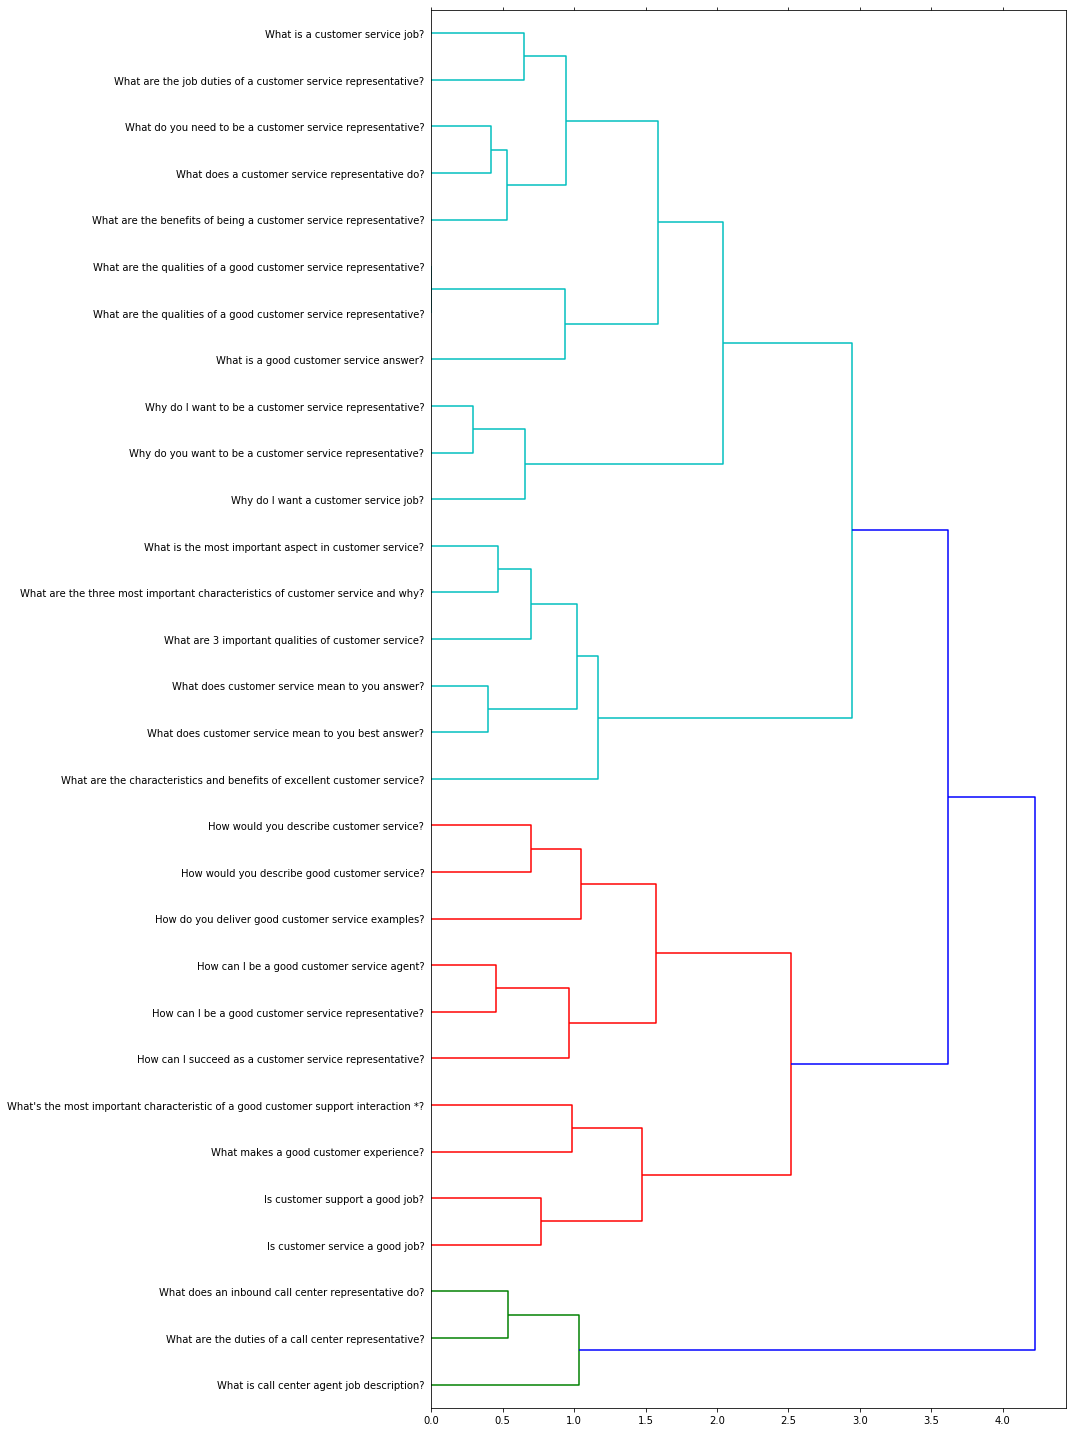

In [17]:
dist = 1 - cosine_similarity(X_w2v)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
plot_dendrogram(linkage_matrix, 'ward_clusters.png')

In [18]:
model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
model.fit_predict(X_w2v)
clusters_ward1 = collections.defaultdict(list)
 
for idx, label in enumerate(model.labels_):
    clusters_ward1[label].append(idx)
    
for i in range(len(clusters_ward1)):
    print("Group", i)
    print(df.loc[clusters_ward1[i], ['question']].to_string(header=False))
    print("====================")

Group 0
6   How would you describe good customer service?     
26  How would you describe customer service?          
29  How do you deliver good customer service examples?
Group 1
2   What are the duties of a call center representative?
12  What is call center agent job description?          
13  What does an inbound call center representative do? 
Group 2
8   What does a customer service representative do?                  
11  What are the job duties of a customer service representative?    
14  What is a customer service job?                                  
16  What are the benefits of being a customer service representative?
17  What do you need to be a customer service representative?        
Group 3
0   What are the qualities of a good customer service representative?
10  What makes a good customer experience?                           
22  What are the qualities of a good customer service representative?
Group 4
4   What are the three most important characteristics of custome

In [20]:
dist = 1 - cosine_similarity(X_w2v_pre)
linkage_matrix = ward(dist) # define the linkage_matrix using ward clustering pre-computed distances
# plot_dendrogram(linkage_matrix, 'ward_clusters_pre.png')

In [21]:
model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
model.fit_predict(X_w2v_pre)
clusters_ward2 = collections.defaultdict(list)
 
for idx, label in enumerate(model.labels_):
    clusters_ward2[label].append(idx)
    
for i in range(len(clusters_ward2)):
    print("Group", i)
    print(df.loc[clusters_ward2[i], ['question']].to_string(header=False))
    print("====================")

Group 0
2   What are the duties of a call center representative?
13  What does an inbound call center representative do? 
Group 1
1   Why do you want to be a customer service representative? 
8   What does a customer service representative do?          
15  Why do I want a customer service job?                    
17  What do you need to be a customer service representative?
24  Why do I want to be a customer service representative?   
Group 2
3   Is customer service a good job?        
9   Is customer support a good job?        
14  What is a customer service job?        
28  What is a good customer service answer?
Group 3
19  What's the most important characteristic of a good customer support interaction *?
21  What is the most important aspect in customer service?                            
Group 4
6   How would you describe good customer service?      
7   What does customer service mean to you best answer?
26  How would you describe customer service?           
27  What does cust

**It looks that the hieraricical method with self-trained w2v vectors is the best**

In [1]:
clusters_ward1

NameError: name 'clusters_ward1' is not defined

## Generate output using the best-performed algo 

In [13]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from pprint import pprint
from gensim.models import Word2Vec


def process_text(text, stem=True):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words=set(stopwords.words('english'))
    
    tokens = [x for x in tokens if x not in stop_words]
    
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    return tokens


questions = list(df['question'])
questions_tokens = [process_text(x) for x in questions]
model = Word2Vec(questions_tokens, min_count=1)
# one extra step for moving from word level to sentence level.
def sent_vectorizer(sent, model):
    sent_vec = []
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model.wv[w]
            else:
                sent_vec = np.add(sent_vec, model.wv[w])
            numw += 1
        except:
            pass
    return np.asarray(sent_vec) / numw

X_w2v = []
for q in questions_tokens:
    X_w2v.append(sent_vectorizer(q, model))
    

from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
model.fit_predict(X_w2v)
clusters_ward1 = collections.defaultdict(list)
 
for idx, label in enumerate(model.labels_):
    clusters_ward1[label].append(idx)
    
for i in range(len(clusters_ward1)):
    print("Group", i)
    print(df.loc[clusters_ward1[i], ['question']].to_string(header=False))
    print("====================")

Group 0
10  Where does a software engineer work?
23  Who can be a software engineer?     
Group 1
6   What skills do you need to be a software engineer?        
21  What certifications do you need to be a software engineer?
26  Can you be a software engineer without a degree?          
27  What do you need to know as a software engineer?          
Group 2
2   Is a software engineer an engineer?           
11  Is software engineer a real engineer?         
12  Is software engineering an engineering degree?
13  Is programming an engineer?                   
14  Is software engineering a type of engineering?
Group 3
9   What is a software engineer job like?
17  Is a software engineer a good job?   
Group 4
1   What exactly does a software engineer do?               
7   What does a software engineer do?                       
8   What is the main work of software engineer?             
22  What is the minimum qualification for software engineer?
Group 5
5   Can anyone be a software engine